In [1]:
import tensorflow as tf
import numpy as np
from train_config import TrainConfig
from utils import TBImUploader, get_new_dir

In [2]:
disc_dropout = tf.placeholder(tf.bool, [], "disc_dropout")
disc_batchnorm = tf.placeholder(tf.bool, [], "disc_batchnorm")
dec_learning_phase = tf.placeholder(tf.bool, [], "dec_learning_phase")

sess = tf.InteractiveSession()

In [3]:
global_step = tf.train.get_or_create_global_step()
train_config = TrainConfig(global_step)

In [4]:
train_config.to_string()

"{'disc_rate': [1.0, 1.0], 'dec_rate': [1.0, 0.7], 'batch_size': 64, 'disc_init_steps': 10000, 'dec_init_steps': 10000, 'label_noise_rate': 0.2, 'disc_BN': True, 'dec_BN': True, 'latent_dim': 32, 'loss_type': 'scientific', 'model_type': 'conv', 'disc_dropout_during_dec_training': True}"

In [5]:
if train_config.model_type == "dense":
    from models.dense import DecoderModel, DiscriminatorModel
elif train_config.model_type == "conv":
    from models.conv import DecoderModel, DiscriminatorModel
else:
    raise RuntimeError("Unknown model type")

In [6]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [7]:
with tf.device("/cpu:0"):
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

    true_data = train_dataset.concatenate(test_dataset)

In [8]:
def preprocess(x, y):
    x = tf.cast(x, tf.float32)
    x -= 125.
    x /= 125.
    x = tf.expand_dims(x, axis=-1)
    return x

In [9]:
with tf.device("/cpu:0"):
    train_dataset = train_dataset.shuffle(x_train.shape[0], reshuffle_each_iteration=False)\
    .shuffle(1024).batch(train_config.batch_size).map(preprocess)
    
    test_dataset = test_dataset.shuffle(x_test.shape[0], reshuffle_each_iteration=False)\
    .batch(256).map(preprocess)

    handle = tf.placeholder(tf.string, [])
    iterator = tf.data.Iterator.from_string_handle(handle, 
                                                   train_dataset.output_types, 
                                                   train_dataset.output_shapes)

    train_iterator = train_dataset.make_initializable_iterator()
    test_iterator = test_dataset.make_initializable_iterator()
    
    next_elt = iterator.get_next()

In [10]:
train_handle = sess.run(train_iterator.string_handle())
test_handle = sess.run(test_iterator.string_handle())

In [11]:
next_elt

<tf.Tensor 'IteratorGetNext:0' shape=(?, 28, 28, 1) dtype=float32>

In [12]:
sess.run(train_iterator.initializer)
sess.run(test_iterator.initializer)

In [13]:
import tensorflow.layers as tfl
import tensorflow.keras.layers as kerasl

In [14]:
decoder_model = DecoderModel(dec_learning_phase, train_config=train_config)

In [15]:
decoder_model(tf.zeros([100, train_config.latent_dim]))

<tf.Tensor 'decoder/conv2d_3/BiasAdd:0' shape=(100, 28, 28, 1) dtype=float32>

In [16]:
discriminator_model = DiscriminatorModel(disc_dropout, disc_batchnorm, train_config=train_config)

In [17]:
if train_config.loss_type == "scientific":
    from losses.scientific import build_gan_losses
elif train_config.loss_type == "working":
    from losses.working import build_gan_losses
else:
    raise RuntimeError("Unknown loss type")

In [18]:
dec_gain, disc_gain = build_gan_losses(decoder_model, discriminator_model, next_elt, train_config)

In [ ]:
def build_gan_update():
    opt = tf.train.AdamOptimizer(learning_rate=0.0002)

#     def build_update(gain, variables):
#         grads = tf.gradients(gain, variables)
#         grads = map(lambda x: tf.clip_by_value(x, -5., 5.), grads)
#         grads_and_vars = [(x,y) for x,y in zip(grads, variables) if x != None]
#         return opt.apply_gradients(grads_and_vars)
    
#     decoder_upd = build_update(dec_gain, decoder_model.get_variables())
#     disc_upd = build_update(disc_gain, discriminator_model.get_variables())
    decoder_upd = opt.minimize(-dec_gain, var_list=decoder_model.get_variables())
    disc_upd = opt.minimize(-disc_gain, var_list=discriminator_model.get_variables())
    return (decoder_upd, disc_upd)

In [ ]:
dec_summaries = decoder_model.get_merged_summaries()
disc_summaries = discriminator_model.get_merged_summaries()

writer = tf.summary.FileWriter(get_new_dir("/home/nikita/tmp/gan_logs/", "{}_{}_".format(train_config.model_type, 
                                                                                         train_config.loss_type)))

In [ ]:
decoder_upd, disc_upd = build_gan_update()
global_step_upd = global_step.assign_add(1)

decoder_upd = [decoder_upd, global_step_upd]
disc_upd = [disc_upd, global_step_upd]

In [ ]:
variable_initializer = tf.global_variables_initializer()
sess.run(variable_initializer)

In [ ]:
from matplotlib import pyplot as plt
num_images = 6

noise = np.random.normal(size=[num_images,train_config.latent_dim]).astype(np.float32)
ggg = decoder_model(tf.constant(noise))
        
im_summarizer = TBImUploader(decoder_model, train_config, 6, writer)
    
def show_pics():
    arr = sess.run(ggg, {dec_learning_phase: False})
    arr = np.concatenate([arr[i] for i in range(arr.shape[0])], axis=1)
    plt.imshow(arr[...,0])
    plt.show()

In [ ]:
train_config.to_string()

"{'disc_rate': [1.0, 1.0], 'dec_rate': [1.0, 0.7], 'batch_size': 64, 'disc_init_steps': 10000, 'dec_init_steps': 10000, 'label_noise_rate': 0.2, 'disc_BN': True, 'dec_BN': True, 'latent_dim': 32, 'loss_type': 'scientific', 'model_type': 'conv', 'disc_dropout_during_dec_training': True}"

In [ ]:
train_config_summ = tf.summary.text("train_config", tf.constant(train_config.to_string()))
writer.add_summary(train_config_summ.eval())

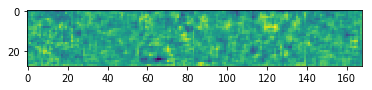

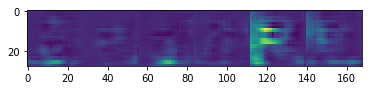

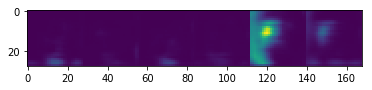

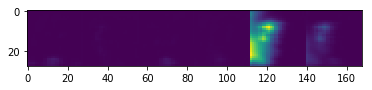

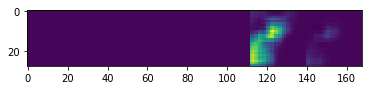

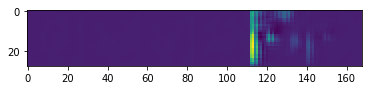

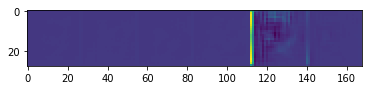

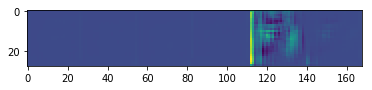

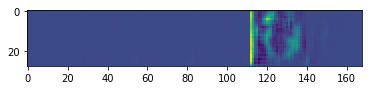

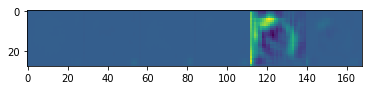

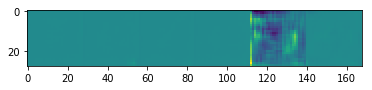

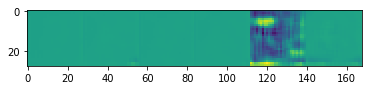

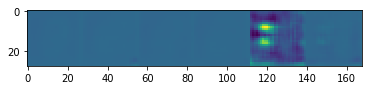

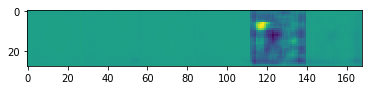

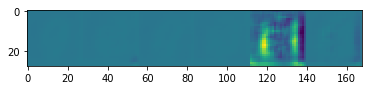

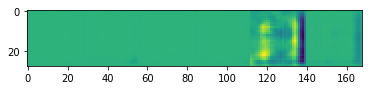

In [ ]:
import random
dec_dic = {handle: train_handle, 
           dec_learning_phase: True, 
           disc_dropout: train_config.disc_dropout_during_dec_training,
           disc_batchnorm: True}

disc_dic = {handle: train_handle, 
            dec_learning_phase: True, 
            disc_dropout: True,
            disc_batchnorm: True}

for epoch in range(100000):
    if epoch % 1 == 0:
        show_pics()
        im_summarizer.post_summary(dec_learning_phase)
    counter = 0
    try:
        while True:
            if random.random() < train_config.get_disc_rate():
                _, summ = sess.run([disc_upd, disc_summaries], disc_dic)
                if counter % 100 == 0:
                    writer.add_summary(summ, global_step.eval())
            
            if random.random() < train_config.get_dec_rate():
                _, summ = sess.run([decoder_upd, dec_summaries], dec_dic)
                if counter % 100 == 0:
                    writer.add_summary(summ, global_step.eval())
            counter += 1
    except tf.errors.OutOfRangeError:
        sess.run(train_iterator.initializer)

In [ ]:
sess.run(variable_initializer)